In [71]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from keras import optimizers
#from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [72]:
data = pd.read_csv('final_input_data_clean_monthly.csv')

In [73]:
data['year'] = pd.to_datetime(data['year'], infer_datetime_format=True)

In [74]:
data.index = pd.to_datetime(data['year'], format='%Y.%m.%d')

In [75]:
new_data = data

In [76]:
new_data

,year,country,iso_code,population,gdp,cement_co2,co2,co2_including_luc,coal_co2,cumulative_cement_co2,...,share_global_cumulative_luc_co2,share_global_cumulative_oil_co2,share_global_luc_co2,share_global_oil_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,output_per_capita
year,,,,,,,,,,,,,,,,,,,,,
1949-01-31,1949-01-31,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.140,0.000,0.160,0.000,0.129,0.000,0.000,0.000,0.0,1.992146
1949-02-28,1949-02-28,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.140,0.000,0.160,0.000,0.129,0.000,0.000,0.000,0.0,1.992146
1949-03-31,1949-03-31,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.140,0.000,0.160,0.000,0.129,0.000,0.000,0.000,0.0,1.992146
1949-04-30,1949-04-30,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.140,0.000,0.160,0.000,0.129,0.000,0.000,0.000,0.0,1.992146
1949-05-31,1949-05-31,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.140,0.000,0.160,0.000,0.129,0.000,0.000,0.000,0.0,1.992146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,2020-09-30,Sri Lanka,LKA,21715076,2.530000e+11,1.511,21.704,31.743,6.335,24.931,...,0.379,0.071,0.247,0.124,0.100,0.001,0.001,0.002,0.0,23037.727340
2020-10-31,2020-10-31,Sri Lanka,LKA,21715076,2.530000e+11,1.511,21.704,31.743,6.335,24.931,...,0.379,0.071,0.247,0.124,0.100,0.001,0.001,0.002,0.0,23037.727340
2020-11-30,2020-11-30,Sri Lanka,LKA,21715076,2.530000e+11,1.511,21.704,31.743,6.335,24.931,...,0.379,0.071,0.247,0.124,0.100,0.001,0.001,0.002,0.0,23037.727340


In [77]:
train_months = new_data.index

new_data.shape

(6943, 35)

In [78]:
#Variables for training
cols = list(new_data)[3:]
#Date and volume columns are not used in training. 
print(cols) 

['population', 'gdp', 'cement_co2', 'co2', 'co2_including_luc', 'coal_co2', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'land_use_change_co2', 'oil_co2', 'share_global_cement_co2', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_coal_co2', 'share_global_cumulative_luc_co2', 'share_global_cumulative_oil_co2', 'share_global_luc_co2', 'share_global_oil_co2', 'share_of_temperature_change_from_ghg', 'temperature_change_from_ch4', 'temperature_change_from_co2', 'temperature_change_from_ghg', 'temperature_change_from_n2o', 'output_per_capita']


In [79]:
#New dataframe with only training data - 5 columns
df_for_training = new_data[cols].astype(float)

In [80]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(6943, 32)

In [81]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 13  # Number of past days we want to use to predict the future.
len_a_start = n_past
len_a = 865 
len_bang_start = len_a + n_past
len_bang = 1766
len_bhu_start = len_bang + n_past
len_bhu = 2379
len_ind_start = len_bhu + n_past
len_ind = 4336
len_nep_start = len_ind + n_past
len_nep = 5189
len_pak_start = len_nep + n_past
len_pak = 6090
len_sri_start = len_pak + n_past
len_sri = 6943 
'''for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])'''
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(len_a_start, len_a - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
for i in range(len_bang_start, len_bang - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
for i in range(len_bhu_start, len_bhu - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
for i in range(len_ind_start, len_ind - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
for i in range(len_nep_start, len_nep - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
for i in range(len_pak_start, len_pak - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
for i in range(len_sri_start, len_sri - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 31])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

trainX shape == (6852, 13, 32).
trainY shape == (6852, 1).


In [82]:
model = Sequential()
initializer = tf.keras.initializers.HeNormal()
#model.add(Dropout(0.6, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True,kernel_initializer = initializer))
model.add(Dropout(0.6))
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False,kernel_initializer = initializer))
model.add(Dropout(0.6))
model.add(Dense(trainY.shape[1]))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
#sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizers.Adam(lr=0.0001, decay=1e-6), loss='mae',metrics=['mse', 'mape',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 13, 64)            24832     
                                                                 
 dropout_4 (Dropout)         (None, 13, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 57,921
Trainable params: 57,921
Non-trainable params: 0
_________________________________________________________________


In [83]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2, verbose=1,callbacks = None)

Epoch 1/10
172/172 [==============================] - 3s 10ms/step - loss: 2.6633 - mse: 39.2928 - mape: 1187.0995 - root_mean_squared_error: 6.2684 - val_loss: 0.7213 - val_mse: 0.8087 - val_mape: 237.6647 - val_root_mean_squared_error: 0.8993
Epoch 2/10
172/172 [==============================] - 1s 8ms/step - loss: 1.4423 - mse: 14.5362 - mape: 635.2681 - root_mean_squared_error: 3.8126 - val_loss: 0.6266 - val_mse: 0.5883 - val_mape: 213.9394 - val_root_mean_squared_error: 0.7670
Epoch 3/10
172/172 [==============================] - 1s 8ms/step - loss: 1.1004 - mse: 12.2958 - mape: 409.4429 - root_mean_squared_error: 3.5065 - val_loss: 0.4577 - val_mse: 0.3363 - val_mape: 145.0090 - val_root_mean_squared_error: 0.5800
Epoch 4/10
172/172 [==============================] - 1s 8ms/step - loss: 0.9109 - mse: 18.5635 - mape: 324.3990 - root_mean_squared_error: 4.3085 - val_loss: 0.4068 - val_mse: 0.2528 - val_mape: 133.2760 - val_root_mean_squared_error: 0.5028
Epoch 5/10
172/172 [======

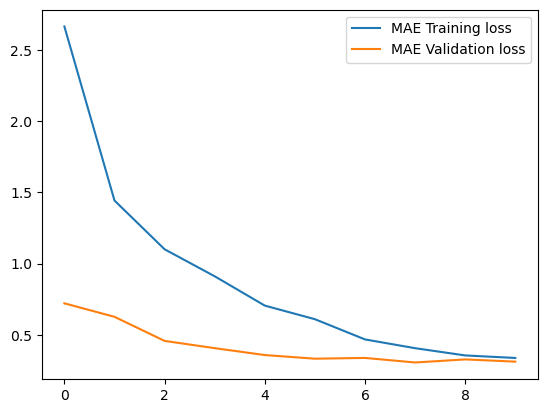

In [84]:
plt.plot(history.history['loss'], label='MAE Training loss')
plt.plot(history.history['val_loss'], label='MAE Validation loss')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


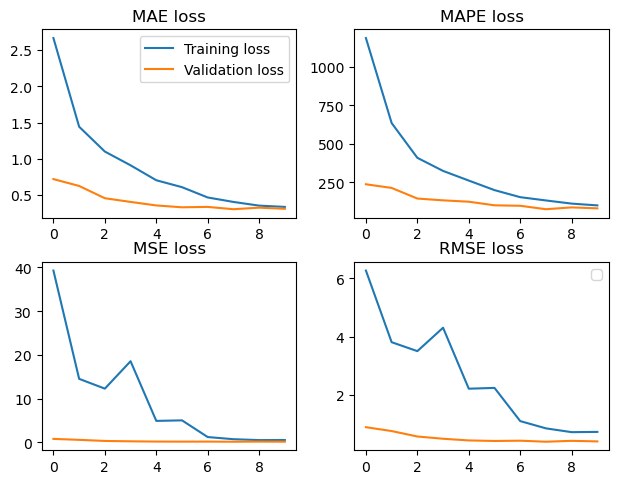

In [85]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(history.history['loss'], label='Training loss')
axis[0, 0].plot(history.history['val_loss'], label='Validation loss')
axis[0,0].set_title('MAE loss')
axis[1,0].set_title('MSE loss')
axis[0,1].set_title('MAPE loss')
axis[1,1].set_title('RMSE loss')
axis[1, 0].plot(history.history['mse'], label='MSE Training loss')
axis[1, 0].plot(history.history['val_mse'], label='MSE Validation loss')
axis[0,0].legend()
axis[0, 1].plot(history.history['mape'], label='MAPE Training loss')
axis[0, 1].plot(history.history['val_mape'], label='MAPE Validation loss')
axis[1, 1].plot(history.history['root_mean_squared_error'], label='RMSE Training loss')
axis[1, 1].plot(history.history['val_root_mean_squared_error'], label='RMSE Validation loss')


In [86]:
s = model.predict(trainX[0:2,:,:])
print(s)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
print(forecast_copies.shape)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,31]
print(y_pred_future)
print(trainY[0:2])
forecast_copies2 = np.repeat(trainY[0:2], df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies2)[:,31]
print(input_rescale)

1/1 [==============================] - 0s 183ms/step
[[-0.5463648 ]
 [-0.54633725]]
(2, 32)
[1725.4835 1725.6661]
[[-0.80462688]
 [-0.80462688]]
[13.22484808 13.22484808]


215/215 [==============================] - 1s 3ms/step
(6852,)
(6852,)


<AxesSubplot:>

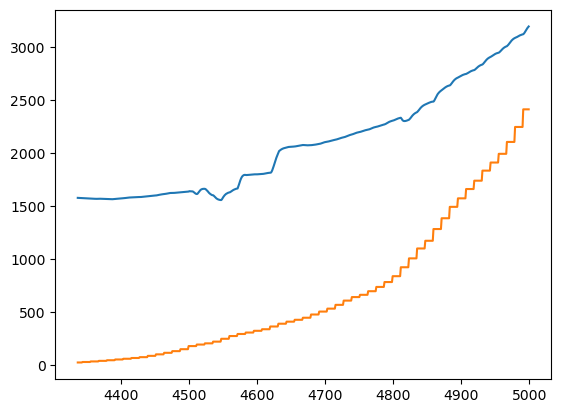

In [87]:
'''s = model.predict(trainX)
years = new_data['year'][0:866]
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,0]
print(input_rescale.shape)
sns.lineplot(years[:],y_pred_future[:866])
sns.lineplot(years[:],input_rescale[:866])'''


s = model.predict(trainX)
years = []
for i in range(6930):
    years.append(i)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,31]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,31]
print(input_rescale.shape)
sns.lineplot(years[4336:5000],y_pred_future[4336:5000])
sns.lineplot(years[4336:5000],input_rescale[4336:5000])

In [88]:
#Forecast for the next 1 year

In [89]:
import tensorflow as tf
import numpy as np

# Generate some dummy data
T = 13  # Sequence length
D = 32   # Number of features
N = 6930  # Number of samples

# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

# Build the model
initializer = tf.keras.initializers.HeNormal()
def build_model(T, D):
    inputs = tf.keras.Input(shape=(T, D))
    x = tf.keras.layers.LSTM(64, return_sequences=True,kernel_initializer = initializer)(inputs)
    x = Attention(64)(x)
    x = tf.keras.layers.Dense(1,kernel_initializer = initializer)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Build and compile the model
model2 = build_model(T, D)
model2.compile(optimizer=optimizers.Adam(lr=0.0001, decay=1e-6), loss="mae",metrics=['mse', 'mape',tf.keras.metrics.RootMeanSquaredError()])
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13, 32)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 13, 64)            24832     
                                                                 
 attention_2 (Attention)     (None, 64)                4225      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 29,122
Trainable params: 29,122
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Train the model
attention_lstm = model2.fit(trainX, trainY, epochs=10, batch_size=32, validation_split = 0.2,verbose = 1,callbacks = None)

Epoch 1/10
172/172 [==============================] - 3s 8ms/step - loss: 0.4451 - mse: 0.6978 - mape: 116.9490 - root_mean_squared_error: 0.8354 - val_loss: 0.5834 - val_mse: 0.6139 - val_mape: 131.9253 - val_root_mean_squared_error: 0.7835
Epoch 2/10
172/172 [==============================] - 1s 6ms/step - loss: 0.1556 - mse: 0.2204 - mape: 30.5470 - root_mean_squared_error: 0.4695 - val_loss: 0.3403 - val_mse: 0.3029 - val_mape: 56.0730 - val_root_mean_squared_error: 0.5504
Epoch 3/10
172/172 [==============================] - 1s 6ms/step - loss: 0.0934 - mse: 0.1057 - mape: 23.4045 - root_mean_squared_error: 0.3250 - val_loss: 0.2668 - val_mse: 0.2070 - val_mape: 48.4770 - val_root_mean_squared_error: 0.4549
Epoch 4/10
172/172 [==============================] - 1s 6ms/step - loss: 0.0721 - mse: 0.0722 - mape: 16.3108 - root_mean_squared_error: 0.2687 - val_loss: 0.2296 - val_mse: 0.1593 - val_mape: 39.6801 - val_root_mean_squared_error: 0.3992
Epoch 5/10
172/172 [==================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


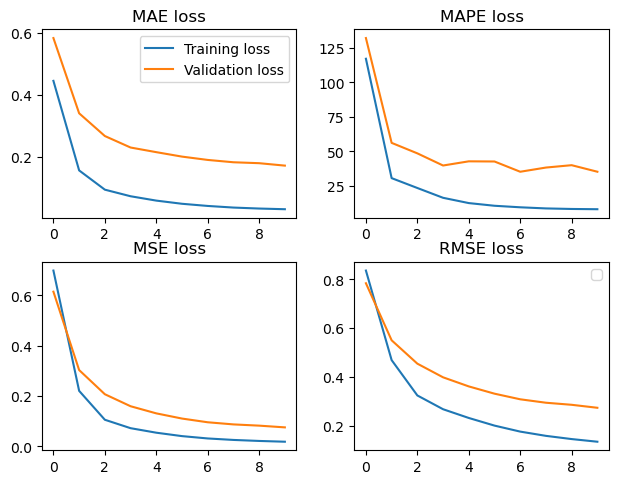

In [91]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(attention_lstm.history['loss'], label='Training loss')
axis[0, 0].plot(attention_lstm.history['val_loss'], label='Validation loss')
axis[0,0].set_title('MAE loss')
axis[1,0].set_title('MSE loss')
axis[0,1].set_title('MAPE loss')
axis[1,1].set_title('RMSE loss')
axis[1, 0].plot(attention_lstm.history['mse'], label='MSE Training loss')
axis[1, 0].plot(attention_lstm.history['val_mse'], label='MSE Validation loss')
axis[0,0].legend()
axis[0, 1].plot(attention_lstm.history['mape'], label='MAPE Training loss')
axis[0, 1].plot(attention_lstm.history['val_mape'], label='MAPE Validation loss')
axis[1, 1].plot(attention_lstm.history['root_mean_squared_error'], label='RMSE Training loss')
axis[1, 1].plot(attention_lstm.history['val_root_mean_squared_error'], label='RMSE Validation loss')


In [92]:
s = model2.predict(trainX[13:15,:,:])
print(s)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
print(forecast_copies.shape)
y_pred_future2 = scaler.inverse_transform(forecast_copies)[:,31]
print(y_pred_future2)
print(trainY[13:15])
forecast_copies2 = np.repeat(trainY[13:15], df_for_training.shape[1], axis=-1)
input_rescale2 = scaler.inverse_transform(forecast_copies2)[:,31]
print(input_rescale2)

1/1 [==============================] - 0s 304ms/step
[[-0.77911514]
 [-0.7799601 ]]
(2, 32)
[182.36578 176.76373]
[[-0.80282613]
 [-0.80282613]]
[25.16369849 25.16369849]


215/215 [==============================] - 0s 2ms/step
(6852,)
(6852,)


<AxesSubplot:>

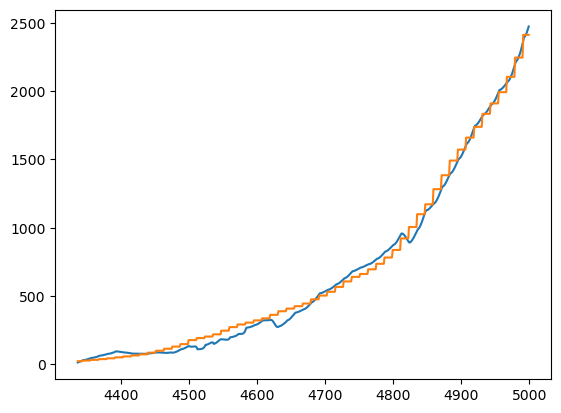

In [93]:
'''s = model.predict(trainX)
years = new_data['year'][0:866]
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,0]
print(input_rescale.shape)
sns.lineplot(years[:],y_pred_future[:866])
sns.lineplot(years[:],input_rescale[:866])'''


s = model2.predict(trainX)
years = []
for i in range(6930):
    years.append(i)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,31]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,31]
print(input_rescale.shape)
sns.lineplot(years[4336:5000],y_pred_future[4336:5000])
sns.lineplot(years[4336:5000],input_rescale[4336:5000])

In [94]:
#Forecast

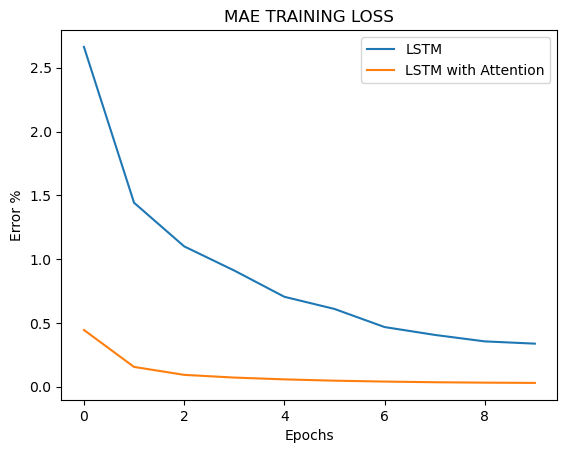

In [95]:
#Comparision between lstm and lstm with attention

plt.plot(history.history['loss'], label='LSTM')
plt.plot(attention_lstm.history['loss'], label='LSTM with Attention')
plt.title("MAE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

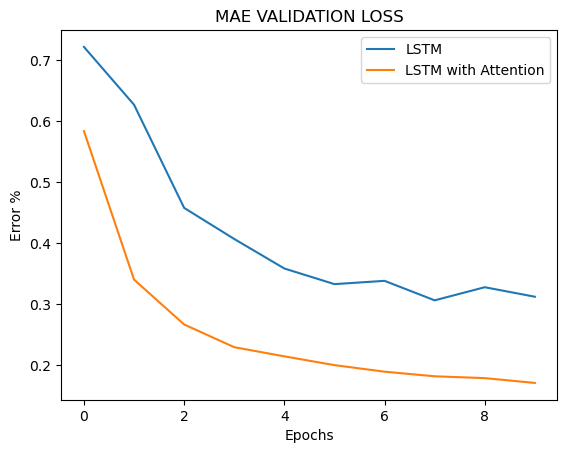

In [96]:
plt.plot(history.history['val_loss'], label='LSTM')
plt.plot(attention_lstm.history['val_loss'], label='LSTM with Attention')
plt.title("MAE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

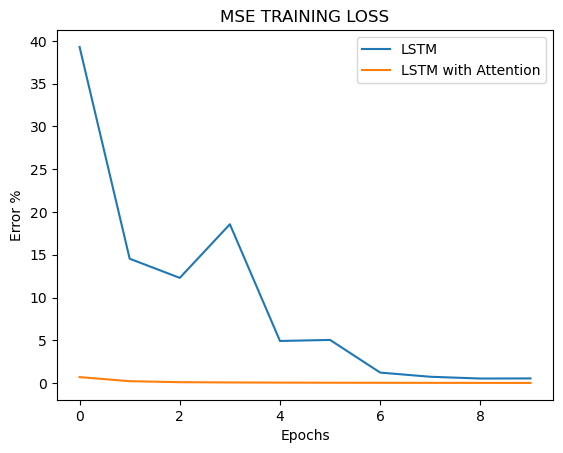

In [97]:
plt.plot(history.history['mse'], label='LSTM')
plt.plot(attention_lstm.history['mse'], label='LSTM with Attention')
plt.title("MSE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

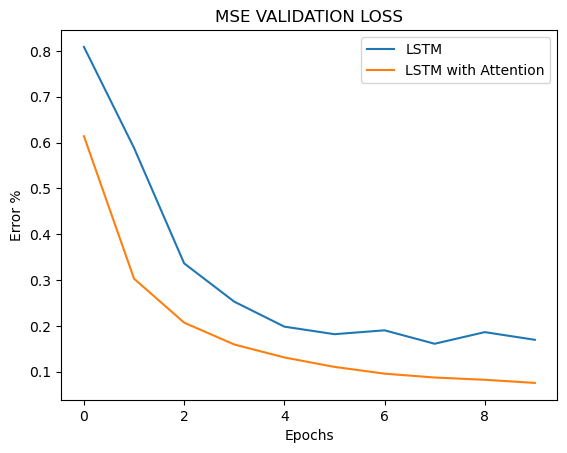

In [98]:
plt.plot(history.history['val_mse'], label='LSTM')
plt.plot(attention_lstm.history['val_mse'], label='LSTM with Attention')
plt.title("MSE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

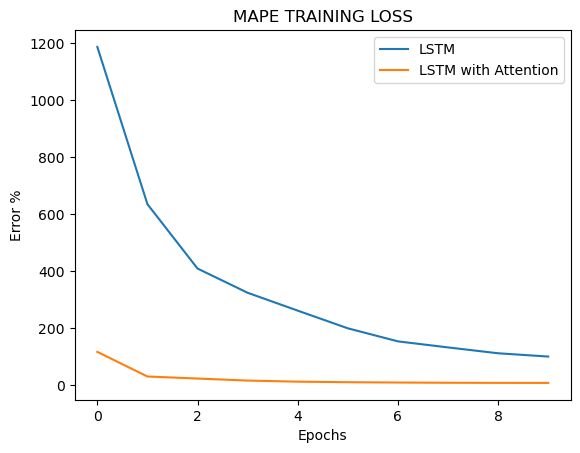

In [99]:
plt.plot(history.history['mape'], label='LSTM')
plt.plot(attention_lstm.history['mape'], label='LSTM with Attention')
plt.title("MAPE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

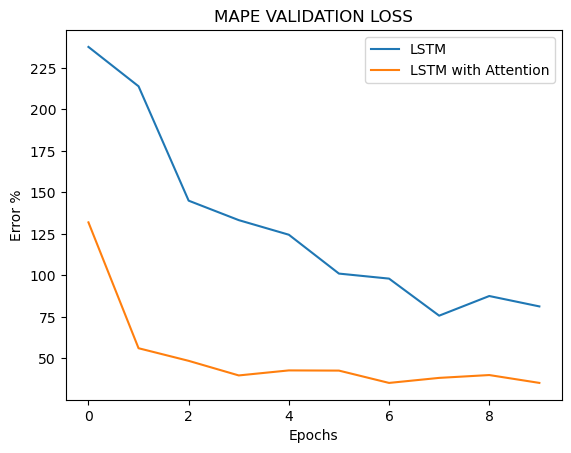

In [100]:
plt.plot(history.history['val_mape'], label='LSTM')
plt.plot(attention_lstm.history['val_mape'], label='LSTM with Attention')
plt.title("MAPE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

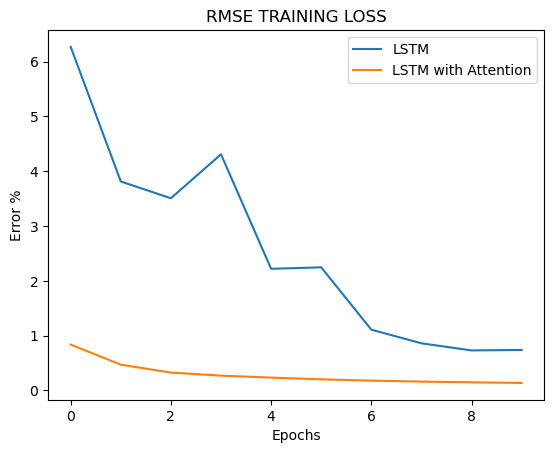

In [101]:
plt.plot(history.history['root_mean_squared_error'], label='LSTM')
plt.plot(attention_lstm.history['root_mean_squared_error'], label='LSTM with Attention')
plt.title("RMSE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

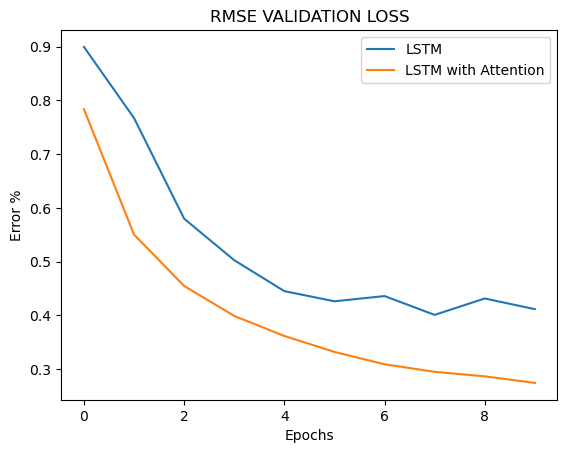

In [102]:
plt.plot(history.history['val_root_mean_squared_error'], label='LSTM')
plt.plot(attention_lstm.history['val_root_mean_squared_error'], label='LSTM with Attention')
plt.title("RMSE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


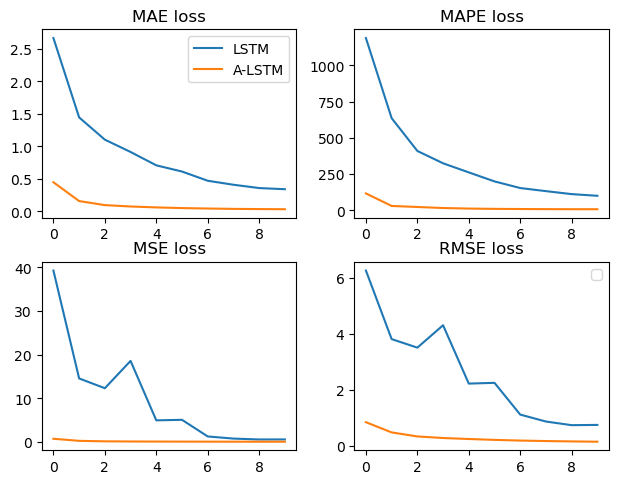

In [103]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(history.history['loss'], label='LSTM')
axis[0, 0].plot(attention_lstm.history['loss'], label='A-LSTM')
axis[0,0].set_title('MAE loss')
axis[1,0].set_title('MSE loss')
axis[0,1].set_title('MAPE loss')
axis[1,1].set_title('RMSE loss')
axis[1, 0].plot(history.history['mse'], label='LSTM')
axis[1, 0].plot(attention_lstm.history['mse'], label='A-LSTM')
axis[0,0].legend()
axis[0, 1].plot(history.history['mape'], label='LSTM')
axis[0, 1].plot(attention_lstm.history['mape'], label='A-LSTM')
axis[1, 1].plot(history.history['root_mean_squared_error'], label='LSTM')
axis[1, 1].plot(attention_lstm.history['root_mean_squared_error'], label='A-LSTM')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


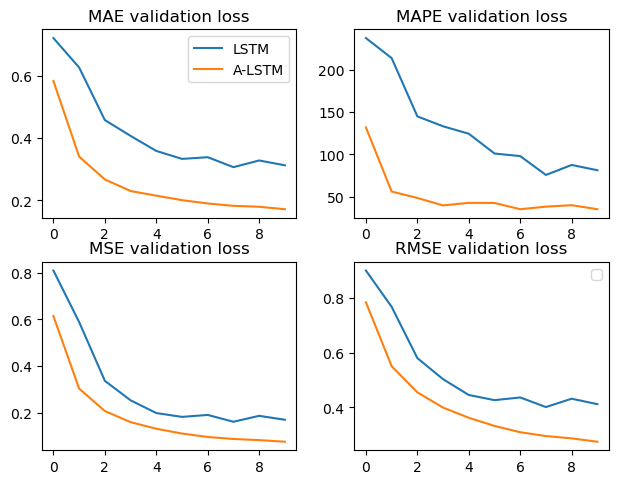

In [104]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(history.history['val_loss'], label='LSTM')
axis[0, 0].plot(attention_lstm.history['val_loss'], label='A-LSTM')
axis[0,0].set_title('MAE validation loss')
axis[1,0].set_title('MSE validation loss')
axis[0,1].set_title('MAPE validation loss')
axis[1,1].set_title('RMSE validation loss')
axis[1, 0].plot(history.history['val_mse'], label='LSTM')
axis[1, 0].plot(attention_lstm.history['val_mse'], label='A-LSTM')
axis[0,0].legend()
axis[0, 1].plot(history.history['val_mape'], label='LSTM')
axis[0, 1].plot(attention_lstm.history['val_mape'], label='A-LSTM')
axis[1, 1].plot(history.history['val_root_mean_squared_error'], label='LSTM')
axis[1, 1].plot(attention_lstm.history['val_root_mean_squared_error'], label='A-LSTM')

### Countrywise prediction along the years (Comparitive) -:

In [ ]:
s = model2.predict(trainX)
years = []
for i in range(6930):
    years.append(i)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,31]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,31]
print(input_rescale.shape)
sns.lineplot(years[4336:5000],y_pred_future[4336:5000])
sns.lineplot(years[4336:5000],input_rescale[4336:5000])



# Afghanistan (1949-2021):
years1 = []
for i in range(72):
    years1.append(i+1949)


# Bangladesh (1946-2021):
years2 = []
for i in range(75):
    years2.append(i+1946)


# Bhutan (1970-2021): 
years3 = []
for i in range(51):
    years3.append(i+1970)


# India (1858-2021): 
years4 = []
for i in range(163):
    years4.append(i+1858)


# Nepal (1950-2021): 
years5 = []
for i in range(71):
    years5.append(i+1950)


# Pakistan (1946-2021): 
years6 = []
for i in range(75):
    years6.append(i+1946)


# Sri Lanka (1950-2021): 
years7 = []
for i in range(71):
    years7.append(i+1950)

